# ENCS5343 :Computer Vision
<h4>Assignment 2: <br> Arabic Handwritten Text Identification Using Local Feature Extraction Techniques </h4>

<h4> <b>Mohammed Abed Alkareem - 1210708</b> </h4>

In [1]:
# install faiss-gpu for faster clustering
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 5.6 MB/s eta 0:00:00


In [2]:
from utils.algorithms import extract_features , sift, orb
import zipfile
import cv2 as cv
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


## Test SIFT and ORB on a single Image

In [ ]:
img1 = cv.imread('test_img.jpg', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('test_img2.jpg', cv.IMREAD_GRAYSCALE)


### SIFT

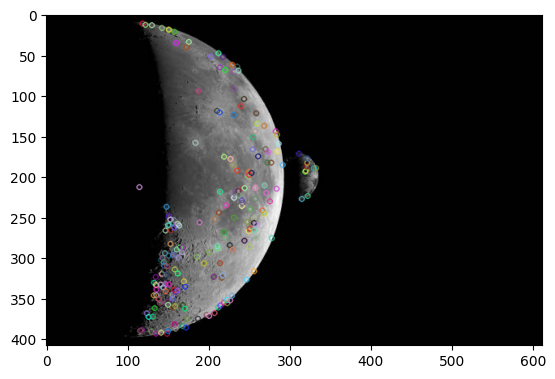

In [ ]:
keypoints1, descriptors1 = sift(img1 , test=True)


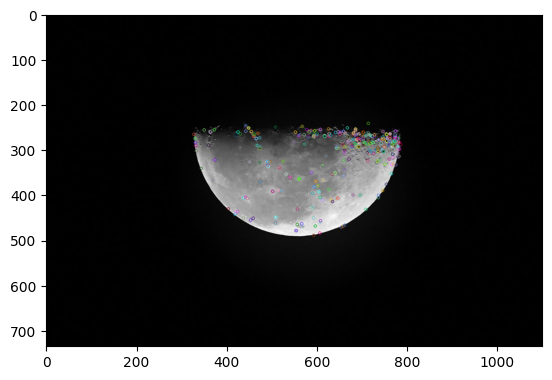

In [ ]:
keypoints2, descriptors2 = sift(img2 , test=True)

In [ ]:
len(keypoints1)

232

In [ ]:
descriptors1.shape

(232, 128)

Number of good matches: 4


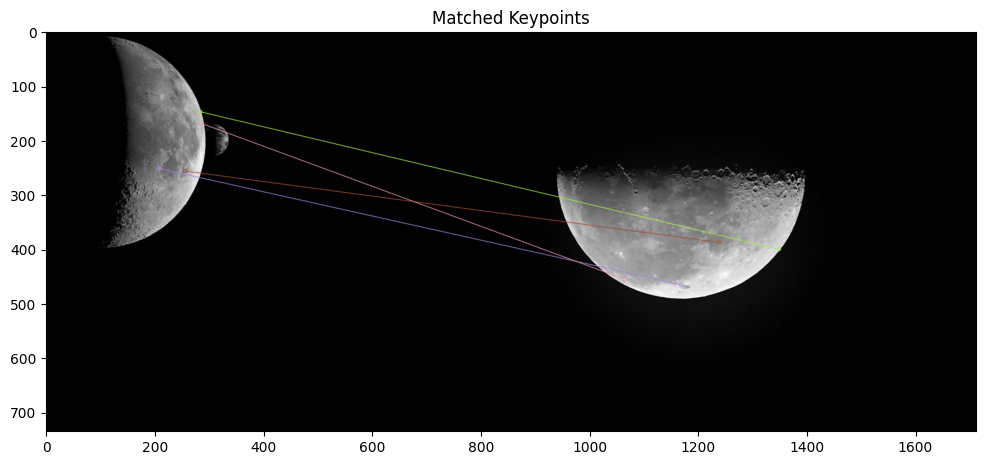

In [ ]:
# Match descriptors using Brute-Force matcher
bf = cv.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Filter matches using Lowe's ratio test
good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

print(f"Number of good matches: {len(good_matches)}")

# Draw matches
matched_image = cv.drawMatches(
    img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Display the result
plt.figure(figsize=(12, 6))
plt.imshow(cv.cvtColor(matched_image, cv.COLOR_BGR2RGB))
plt.title('Matched Keypoints')
plt.show()

### ORB

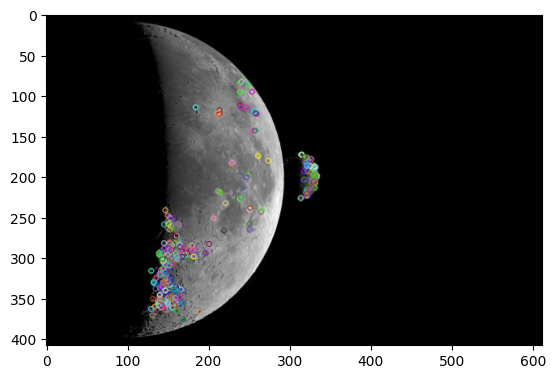

In [ ]:
keypoints1, descriptors1 = orb(img1 , test=True)

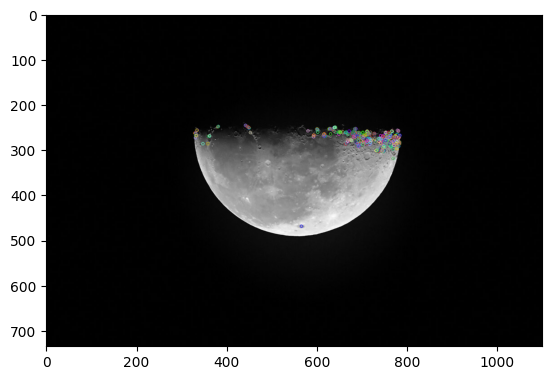

In [ ]:
keypoints2, descriptors2 = orb(img2 , test=True)

In [ ]:
len(keypoints1)

471

In [ ]:
descriptors1.shape

(471, 32)

Number of good matches: 0


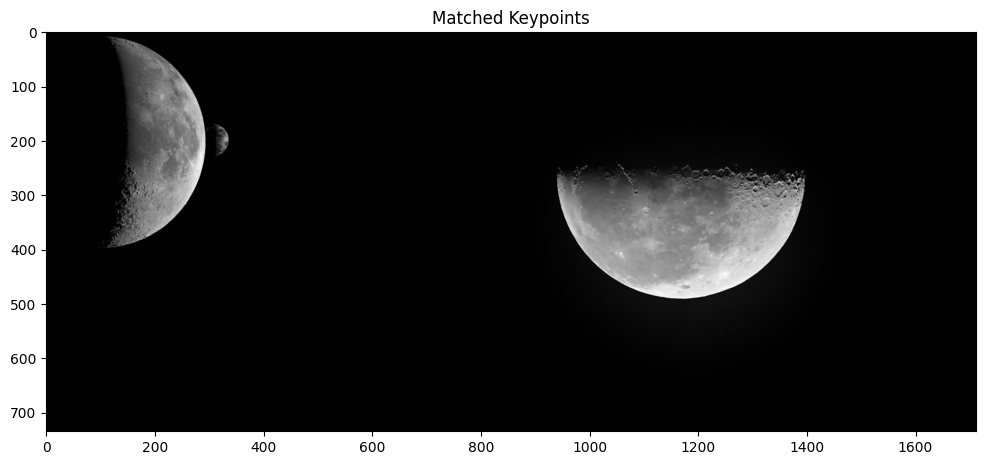

In [ ]:
# Match descriptors using Brute-Force matcher
bf = cv.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Filter matches using Lowe's ratio test
good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

print(f"Number of good matches: {len(good_matches)}")

# Draw matches
matched_image = cv.drawMatches(
    img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Display the result
plt.figure(figsize=(12, 6))
plt.imshow(cv.cvtColor(matched_image, cv.COLOR_BGR2RGB))
plt.title('Matched Keypoints')
plt.show()

## Dataset Download

Dataset Link: https://data.mendeley.com/datasets/2h76672znt/1/files/9031138a-b812-433e-a704-8acb1707936e

<p>The dataset contains 65 different Arabic alphabets (with variations on begin, middle, end and regular alphabets), 10 different Arabic words (that encompass all Arabic alphabets) and 3 different paragraphs. The dataset was collected anonymously from 82 different users. Each user was asked to write each alphabet and word 10 times. A userid uniquely but anonymously identifies the writer of each alphabet, word and paragraph. In total, the dataset consists of 53199 alphabet images, 8144 word images and 241 paragraph images.</p>

- The file **"isolated_words_per_user.zip"** contains 8144 Arabic words organized into one folder per user

In [3]:
# download the dataset from the Mendeley Data
!wget https://data.mendeley.com/public-files/datasets/2h76672znt/files/9031138a-b812-433e-a704-8acb1707936e/file_downloaded -O isolated_words_per_user.zip

--2024-12-04 06:54:36--  https://data.mendeley.com/public-files/datasets/2h76672znt/files/9031138a-b812-433e-a704-8acb1707936e/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/56076a80-b848-4c11-bc65-fa1a0423c35e [following]
--2024-12-04 06:54:37--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/56076a80-b848-4c11-bc65-fa1a0423c35e
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 52.218.101.248, 52.92.4.34, 52.92.3.146, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|52.218.101.248|:44

In [4]:
# unzip the dataset


with zipfile.ZipFile('isolated_words_per_user.zip', 'r') as zip_ref:
    zip_ref.extractall('isolated_words_per_user')

## Procedure

### Importing Libraries

In [5]:
root_dir = './isolated_words_per_user/isolated_words_per_user'

In [6]:
sorted(os.listdir(root_dir))

dataset = []

for label in sorted(os.listdir(root_dir)):

    class_dir = os.path.join(root_dir, label)
    if not os.path.isdir(class_dir):
        continue
    for img_name in os.listdir(class_dir):

        if not img_name.endswith('.png'):
            continue
        img_path = os.path.join(class_dir, img_name)
        img = cv.imread(img_path)
        # if not grey scale make it
        if len(img.shape) > 2:
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        if img is None:
            continue

        dataset.append({
            'img': img,
            'label': label
        })


In [7]:
#make the dataset dataframe
df = pd.DataFrame(dataset)

In [ ]:
images = df['img'].tolist()
labels = df['label'].tolist()

time_extraction, clustering_time, forming_time = extract_features(
                                                                  images,
                                                                  labels,
                                                                  algorithm='sift',
                                                                  numOfClusters=1000,
                                                                  Compare=True
                                                              )

print(f"Average Time taken for feature extraction using SIFT: {sum(time_extraction)/len(time_extraction):.5f} seconds")
print(f"Time taken for clustering: {clustering_time:.2f} seconds")
print(f"Time taken for forming the feature vectors: {forming_time:.2f} seconds")

print("======================================\n\n")


time_extraction, clustering_time, forming_time = extract_features(
                                                                  images,
                                                                  labels,
                                                                  algorithm='orb',
                                                                  numOfClusters=1000,
                                                                  Compare=True
                                                              )

print(f"Average Time taken for feature extraction using ORB: {sum(time_extraction)/len(time_extraction):.5f} seconds")
print(f"Time taken for clustering: {clustering_time:.2f} seconds")
print(f"Time taken for forming the feature vectors: {forming_time:.2f} seconds")

print("======================================\n\n")



Number of processed images:  8144
Average number of keypoints per image:  90.99803536345776
Average time for feature extraction:  0.01072116559170084
Clustering descriptors...
Using GPU: True
Clustering complete. Number of clusters: 1000
Clustering time: 2.54 seconds
Forming feature vectors...
Forming time: 2.79 seconds
Average Time taken for feature extraction using SIFT: 0.01072 seconds
Time taken for clustering: 2.54 seconds
Time taken for forming the feature vectors: 2.79 seconds


Number of processed images:  8144
Average number of keypoints per image:  175.93848231827113
Average time for feature extraction:  0.0013545245400580536
Clustering descriptors...
Using GPU: True
Clustering complete. Number of clusters: 1000
Clustering time: 0.95 seconds
Forming feature vectors...
Forming time: 5.64 seconds
Average Time taken for feature extraction using ORB: 0.00135 seconds
Time taken for clustering: 0.95 seconds
Time taken for forming the feature vectors: 5.64 seconds




In [8]:
def split_data(df, target_column, val_size=0.2, test_size=0.2):
    train_size = 1 - val_size - test_size
    # Split the dataset into features and target
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Split the dataset into training, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    val_size = val_size / (train_size + val_size)  # Calculate the relative size of the validation set

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [9]:

X_train, X_val, X_test, y_train, y_val, y_test = split_data(df, 'label', val_size=0.2, test_size=0.2)


In [ ]:
# Extract features for training data
train_images = X_train['img'].tolist()
train_labels = y_train.tolist()
print("Extracting features for training data...")
train_features, train_labels, kmeans = extract_features(
                                        images=train_images,
                                        labels=train_labels,
                                        algorithm='sift',
                                        numOfClusters=1500,
                                        )

# Extract features for testing data using the trained kMeans
val_images = X_val['img'].tolist()
val_labels = y_val.tolist()
print("Extracting features for testing data...")
val_features, val_labels = extract_features(
    images=val_images,
    labels=val_labels,
    algorithm='sift',
    Test=True,
    kMeans=kmeans
)


Extracting features for training data...
Number of processed images:  4886
Clustering descriptors...
Using GPU: True
Clustering complete. Number of clusters: 1500
Forming feature vectors...
Extracting features for testing data...
Number of processed images:  1629


In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# Dictionary of classifiers
classifiers = {
    "SVM": SVC(random_state=42, C=10, kernel='rbf', gamma='auto'),
    "RandomForest": RandomForestClassifier(random_state=42, n_estimators=100),
    "kNN": KNeighborsClassifier(n_neighbors=5),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42)
}

# Train and evaluate each classifier
results = {}
for name, clf in classifiers.items():
    print(f"Training {name}...")
    clf.fit(train_features, train_labels)
    predictions = clf.predict(val_features)
    accuracy = accuracy_score(val_labels, predictions)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.2f}")


Training SVM...
SVM Accuracy: 0.01
Training RandomForest...
RandomForest Accuracy: 0.19
Training kNN...
kNN Accuracy: 0.04
Training LogisticRegression...
LogisticRegression Accuracy: 0.21


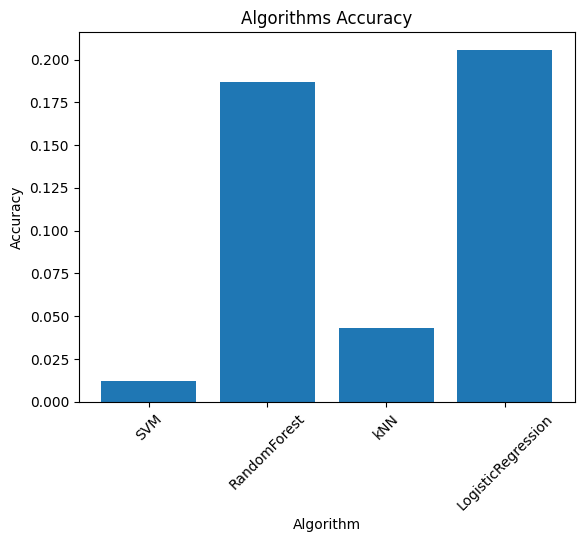

In [ ]:
# Visualize results
plt.bar(results.keys(), results.values())
plt.title("Algorithms Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Algorithm")
plt.xticks(rotation=45)
plt.show()

## Different clustering number

In [ ]:
algorithms = ['sift', 'orb']
clusters = list(range(100, 4500, 600))

accuracy_results = []

train_images = X_train['img'].tolist()
train_labels = y_train.tolist()

val_images = X_val['img'].tolist()
val_labels = y_val.tolist()

for algorithm in algorithms:
    for numOfClusters in clusters:
        print(f"Algorithm: {algorithm}, Number of Clusters: {numOfClusters}")

        # Extract features for training data
        print("Extracting features for training data...")
        train_features, train_labels, kmeans = extract_features(
                                                images=train_images,
                                                labels=train_labels,
                                                algorithm=algorithm,
                                                numOfClusters=numOfClusters,
                                                )

        # Extract features for testing data using the trained kMeans
        print("Extracting features for validation data...")
        val_features, val_labels = extract_features(
            images=val_images,
            labels=val_labels,
            algorithm=algorithm,
            Test=True,
            kMeans=kmeans
        )

        lr_clf = LogisticRegression(max_iter=1000, random_state=42)

        # Train the lr_clf classifier
        print("Training the classifier...")
        lr_clf.fit(train_features, train_labels)

              # Make predictions
        print("Making predictions...")

        train_pred = lr_clf.predict(train_features)
        train_accuracy = accuracy_score(train_labels, train_pred)
        print(f"Accuracy on training set: {train_accuracy:.2f}")



        predictions = lr_clf.predict(val_features)
        # Calculate accuracy
        accuracy = accuracy_score(val_labels, predictions)
        print(f"Accuracy on validation set: {accuracy:.2f}")

        accuracy_results.append({
            'algorithm': algorithm,
            'numOfClusters': numOfClusters,
            'Training accuracy': train_accuracy,
            'Validation accuracy': accuracy
        })

        print("======================================\n\n")

Algorithm: sift, Number of Clusters: 100
Extracting features for training data...
Number of processed images:  4886
Clustering descriptors...
Using GPU: True
Clustering complete. Number of clusters: 100
Forming feature vectors...
Extracting features for validation data...
Number of processed images:  1629
Training the classifier...
Making predictions...
Accuracy on training set: 0.19
Accuracy on validation set: 0.11


Algorithm: sift, Number of Clusters: 700
Extracting features for training data...
Number of processed images:  4886
Clustering descriptors...
Using GPU: True
Clustering complete. Number of clusters: 700
Forming feature vectors...
Extracting features for validation data...
Number of processed images:  1629
Training the classifier...
Making predictions...
Accuracy on training set: 0.48
Accuracy on validation set: 0.18


Algorithm: sift, Number of Clusters: 1300
Extracting features for training data...
Number of processed images:  4886
Clustering descriptors...
Using GPU: Tr

<Figure size 1000x600 with 0 Axes>

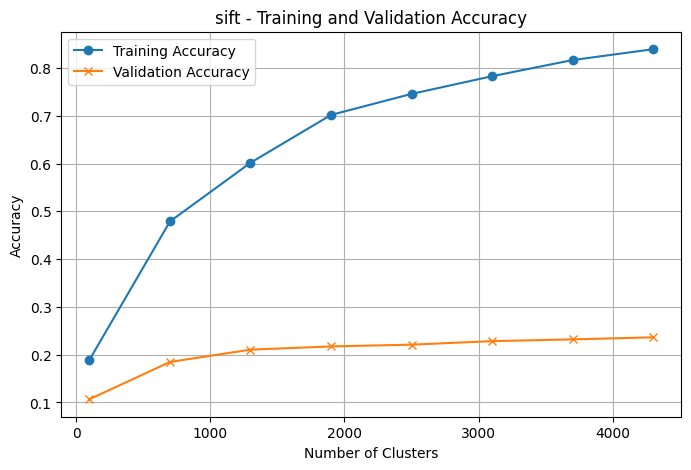

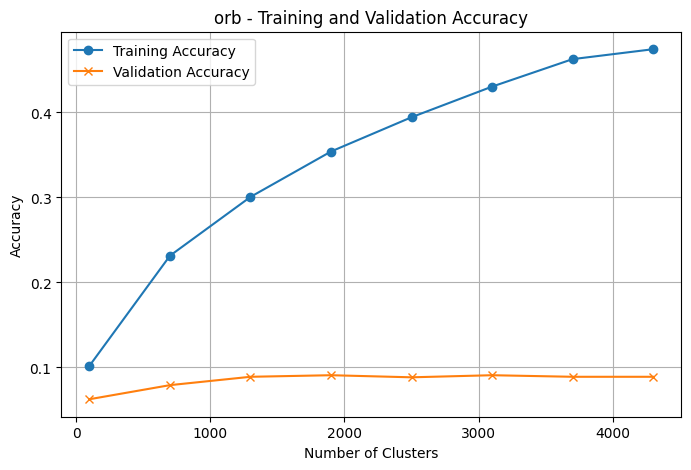

In [ ]:
# Convert the results into a DataFrame for easier handling
result_df = pd.DataFrame(accuracy_results)

# Plotting
plt.figure(figsize=(10, 6))


# Plotting
algorithms = result_df['algorithm'].unique()

for algorithm in algorithms:
    plt.figure(figsize=(8, 5))
    group = result_df[result_df['algorithm'] == algorithm]
    plt.plot(group['numOfClusters'], group['Training accuracy'], label='Training Accuracy', marker='o')
    plt.plot(group['numOfClusters'], group['Validation accuracy'], label='Validation Accuracy', marker='x')

    plt.title(f'{algorithm} - Training and Validation Accuracy')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

## Robusteness check
to check robustness different version of the test set will be generated each to check a side of the robustness

In [11]:
import random
import cv2 as cv
import numpy as np

# Define individual transformation functions
def add_gaussian_noise(image):
    return cv.GaussianBlur(image, (5, 5), 0)

def random_rotation(image):
    angle = random.uniform(-30, 30)
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv.getRotationMatrix2D(center, angle, 1.0)
    return cv.warpAffine(image, rotation_matrix, (w, h))

def scale_object_in_image(image):
    # Original image dimensions
    original_h, original_w = image.shape[:2]

    # Random scaling factor
    scale_factor = random.uniform(0.5, 1.5)

    # Resize the image (object)
    resized_image = cv.resize(image, (0, 0), fx=scale_factor, fy=scale_factor)

    # Get new dimensions after scaling
    new_h, new_w = resized_image.shape[:2]

    # Create a blank canvas of the original size
    canvas = np.ones_like(image) * 255

    # Determine placement to center the resized object
    start_y = max((original_h - new_h) // 2, 0)
    start_x = max((original_w - new_w) // 2, 0)

    # Crop or pad the resized image to fit into the canvas
    crop_y = min(new_h, original_h)
    crop_x = min(new_w, original_w)

    # Place the resized object into the canvas
    canvas[start_y:start_y+crop_y, start_x:start_x+crop_x] = resized_image[:crop_y, :crop_x]

    return canvas


def change_illumination(image):
    alpha = random.uniform(0.8, 1.5)  # Contrast
    beta = random.randint(-30, 30)    # Brightness
    return cv.convertScaleAbs(image, alpha=alpha, beta=beta)


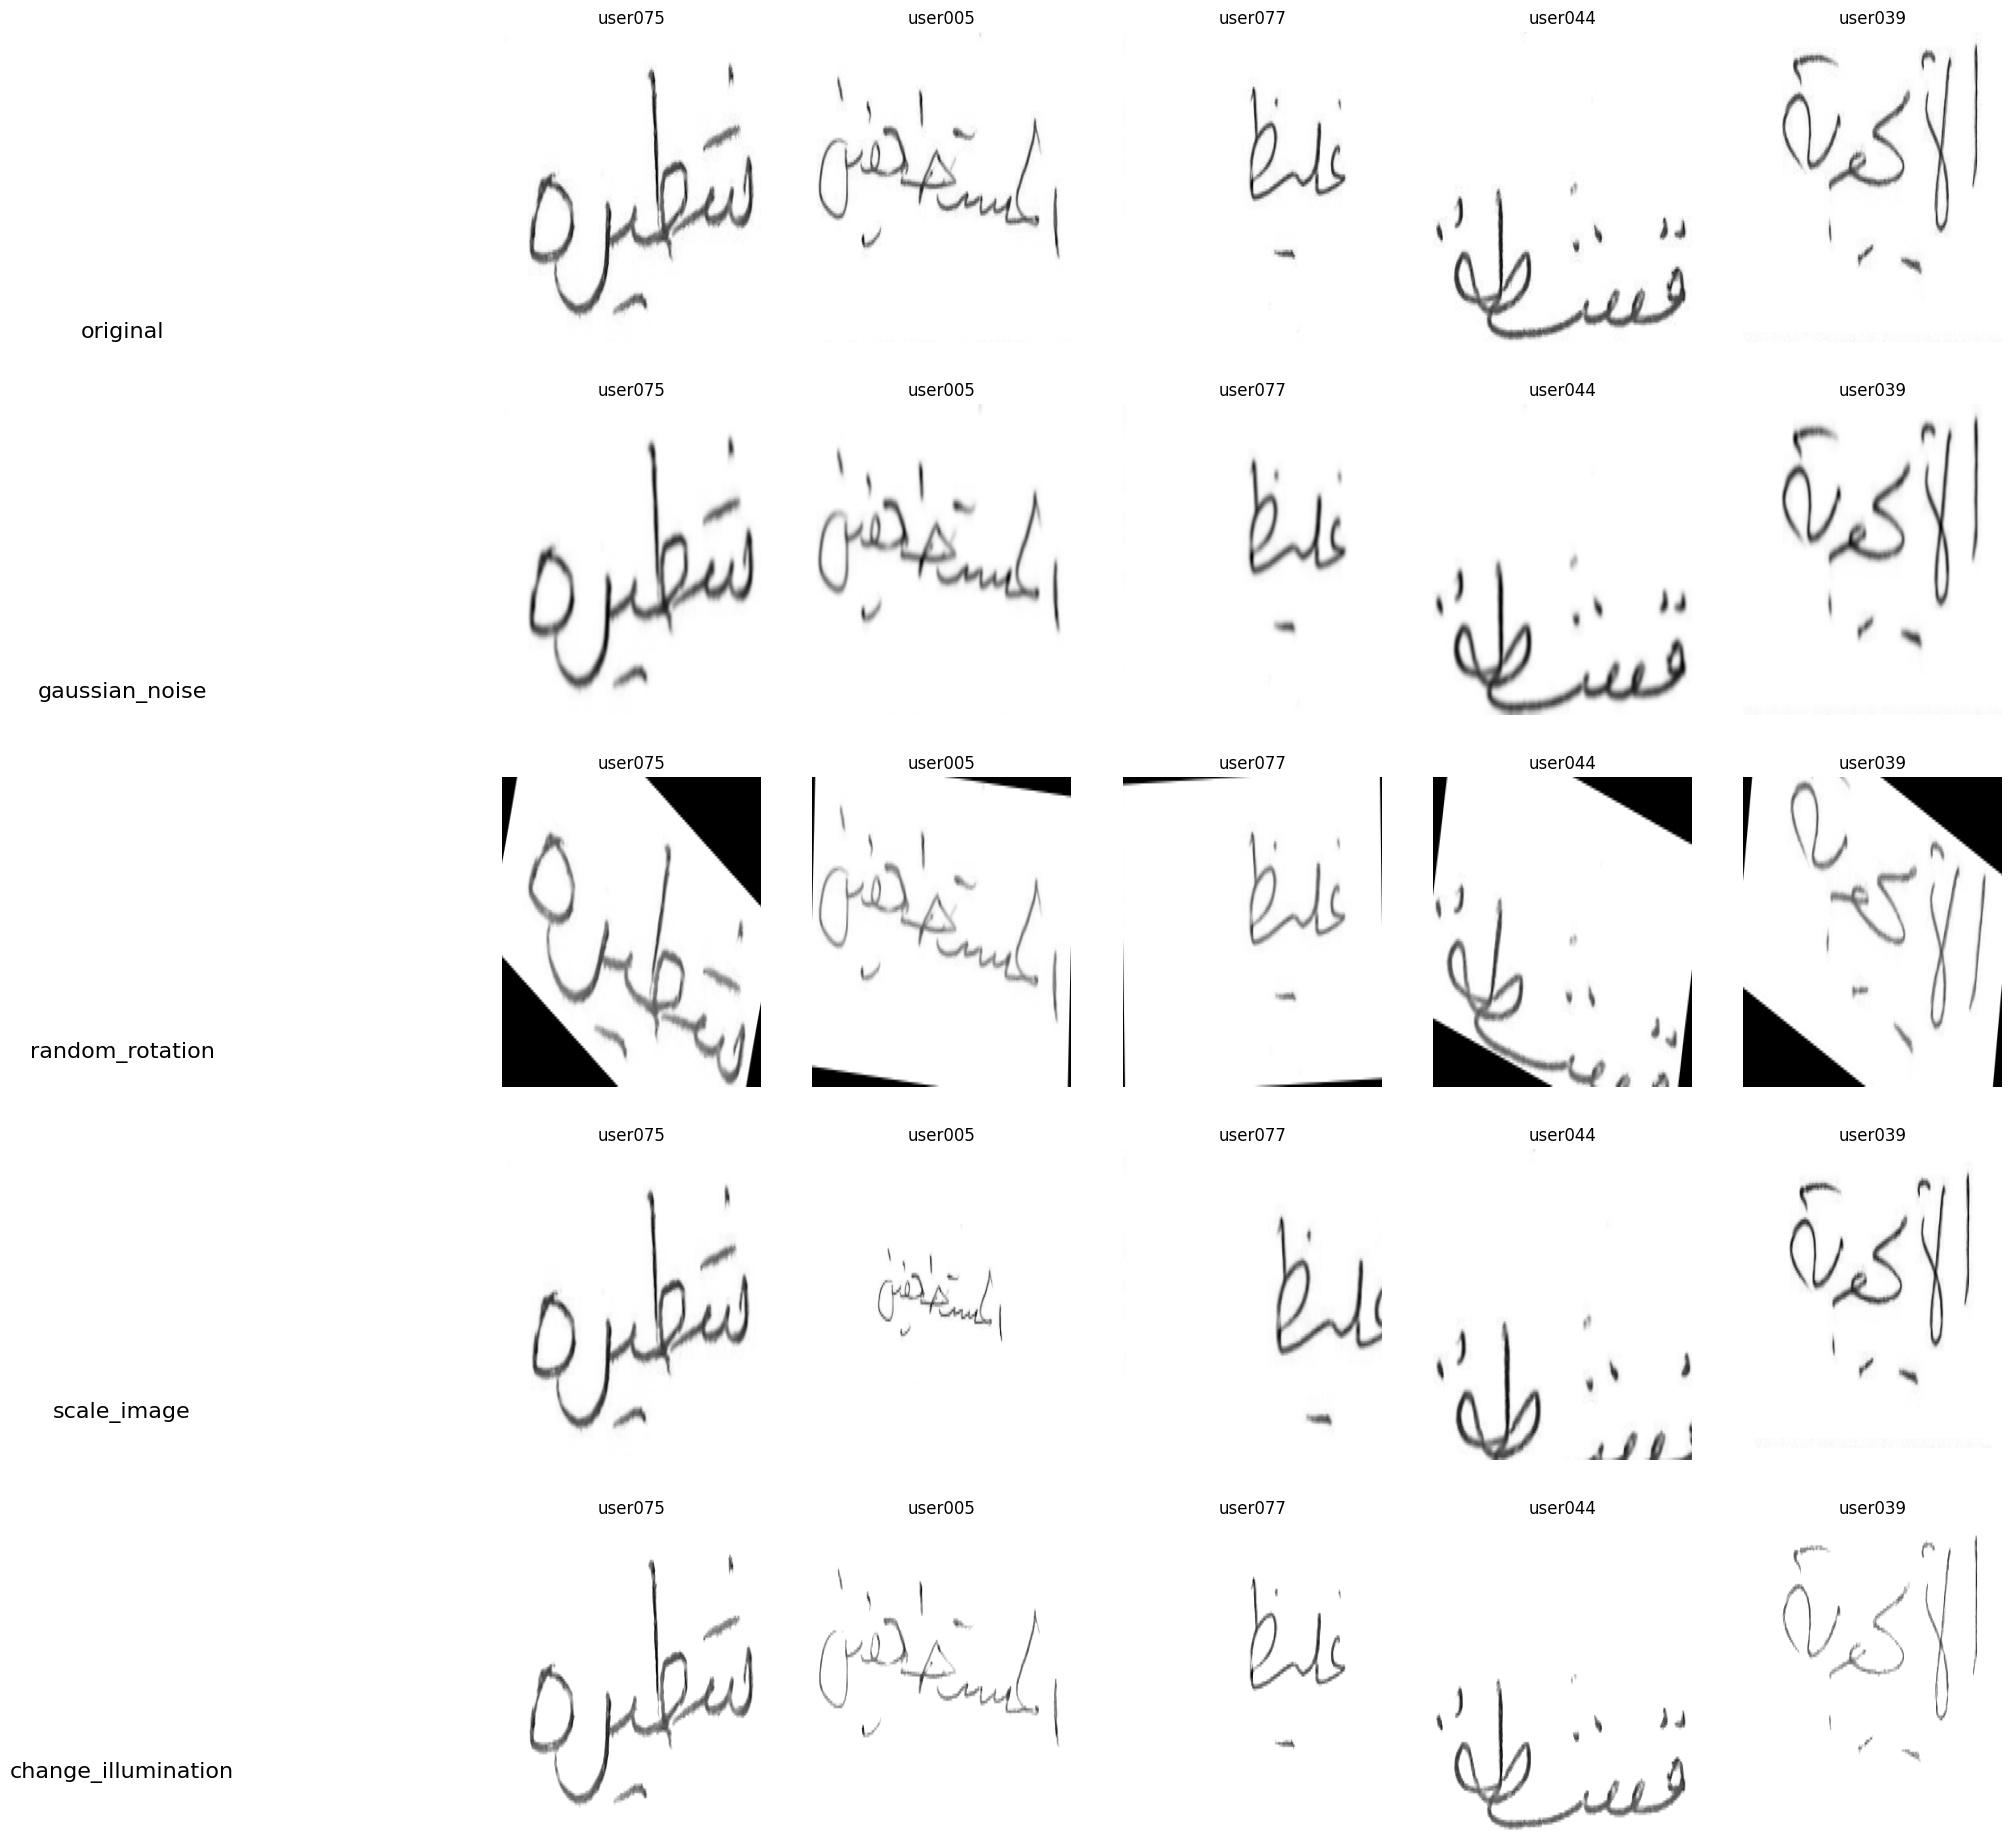

In [12]:

test_data_sets = {}

# Original
test_data_sets['original'] = X_test.copy()

# Add Gaussian noise
test_data_sets['gaussian_noise'] = X_test.copy()
test_data_sets['gaussian_noise']['img'] = test_data_sets['gaussian_noise']['img'].apply(add_gaussian_noise)

# Random rotation
test_data_sets['random_rotation'] = X_test.copy()
test_data_sets['random_rotation']['img'] = test_data_sets['random_rotation']['img'].apply(random_rotation)

# Scale image
test_data_sets['scale_image'] = X_test.copy()
test_data_sets['scale_image']['img'] = test_data_sets['scale_image']['img'].apply(scale_object_in_image)


# Change illumination
test_data_sets['change_illumination'] = X_test.copy()
test_data_sets['change_illumination']['img'] = test_data_sets['change_illumination']['img'].apply(change_illumination)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 5, figsize=(20, 20))

# Adjust spacing for text
plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.05)

# Loop through each dataset and display the images
for i, (data_set, data) in enumerate(test_data_sets.items()):
    # Add text for "change_illumination" label
    fig.text(0.01, 0.8 - i * 0.18, list(test_data_sets.keys())[i], fontsize=16, ha='center', va='center')

    for j in range(5):
        axes[i, j].imshow(data['img'].iloc[j], cmap='gray')
        axes[i, j].set_title(y_test.iloc[j])
        axes[i, j].axis('off')
        axes[i, j].set_aspect('auto')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].set_xticklabels([])
        axes[i, j].set_yticklabels([])
        axes[i, j].grid(False)
        if j == 0:
            axes[i, j].set_ylabel(data_set, fontsize=16)

plt.show()




In [13]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# Define algorithms and number of clusters
algorithms = ['sift', 'orb']
numOfClusters = 1300
accuracy_results = []

# Loop through each algorithm
for algorithm in algorithms:
    print(f"Algorithm: {algorithm}, Number of Clusters: {numOfClusters}")

  # Extract features for training data
    train_images = X_train['img'].tolist()
    train_labels = y_train.tolist()
    print("Extracting features for training data...")
    train_features, train_labels, kmeans = extract_features(
        images=train_images,
        labels=train_labels,
        algorithm=algorithm,
        numOfClusters=numOfClusters
    )

    # Initialize Logistic Regression classifier
    lr_clf = LogisticRegression(max_iter=1000, random_state=42)

        # Train the Logistic Regression classifier
    print("Training the Logistic Regression classifier...")
    lr_clf.fit(train_features, train_labels)



    # Loop through each test dataset
    for test_set in test_data_sets.keys():
        print(f"Test Set: {test_set}")



        # Extract features for testing data using the trained kMeans
        test_images = test_data_sets[test_set]['img'].tolist()
        test_labels = y_test.tolist()
        print("Extracting features for testing data...")
        test_features, test_labels = extract_features(
            images=test_images,
            labels=test_labels,
            algorithm=algorithm,
            Test=True,
            kMeans=kmeans
        )


        # Make predictions
        print("Making predictions...")
        predictions = lr_clf.predict(test_features)

        # Calculate accuracy
        accuracy = accuracy_score(test_labels, predictions)
        print(f"Accuracy: {accuracy:.2f}")

        # Save results
        accuracy_results.append({
            'algorithm': algorithm,
            'robustness': test_set,
            'accuracy': accuracy
        })

        print("======================================\n\n")


# End of workflow
print("All tests completed.")


Algorithm: sift, Number of Clusters: 1300
Extracting features for training data...
Number of processed images:  4886
Clustering descriptors...
Using GPU: True
Clustering complete. Number of clusters: 1300
Forming feature vectors...
Training the Logistic Regression classifier...
Test Set: original
Extracting features for testing data...
Number of processed images:  1629
Making predictions...
Accuracy: 0.21


Test Set: gaussian_noise
Extracting features for testing data...
Number of processed images:  1629
Making predictions...
Accuracy: 0.10


Test Set: random_rotation
Extracting features for testing data...
Number of processed images:  1629
Making predictions...
Accuracy: 0.18


Test Set: scale_image
Extracting features for testing data...
Number of processed images:  1628
Making predictions...
Accuracy: 0.16


Test Set: change_illumination
Extracting features for testing data...
Number of processed images:  1626
Making predictions...
Accuracy: 0.17


Algorithm: orb, Number of Clusters

sift
orb


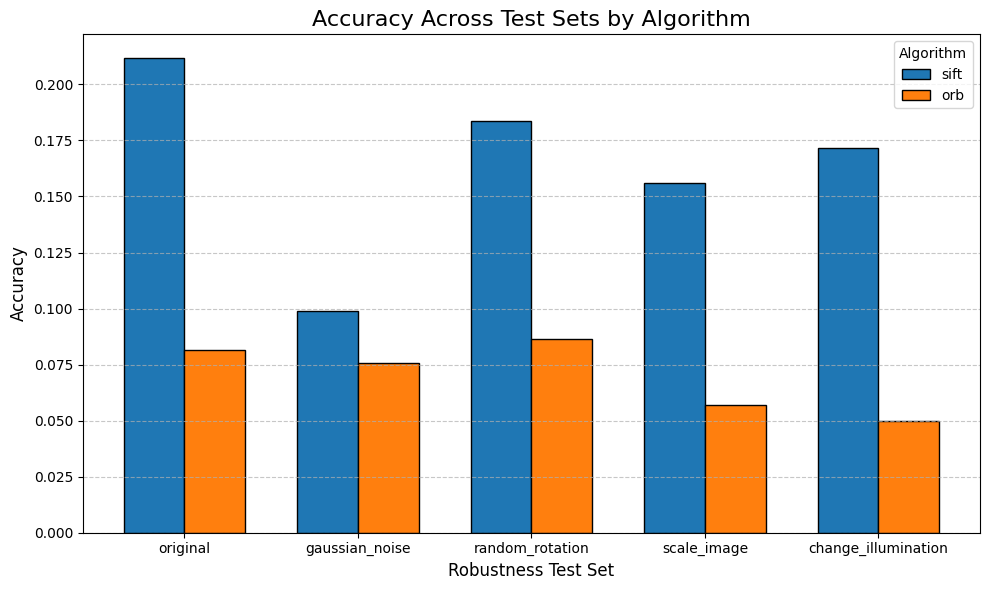

In [14]:
# Convert results to a DataFrame
result_df = pd.DataFrame(accuracy_results)

# Prepare data for grouped bar chart
robustness_sets = result_df['robustness'].unique()
algorithms = result_df['algorithm'].unique()
x = np.arange(len(robustness_sets))  # X positions for the groups

# Bar width for grouping
bar_width = 0.35

# Plot grouped bar chart
plt.figure(figsize=(10, 6))

for i, algorithm in enumerate(algorithms):
    print(algorithm)
    subset = result_df[result_df['algorithm'] == algorithm]
    plt.bar(x + i * bar_width, subset['accuracy'], width=bar_width, label=algorithm, edgecolor='black')

# Add labels and legend
plt.title('Accuracy Across Test Sets by Algorithm', fontsize=16)
plt.xlabel('Robustness Test Set', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(x + bar_width / 2, robustness_sets, fontsize=10)  # Adjust ticks to center
plt.yticks(fontsize=10)

plt.legend(title='Algorithm', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()